In [1]:
import pickle
import pandas as pd

from test import read_data

In [2]:
edges = read_data()
df = pd.DataFrame(edges, columns=['u', 'i', 't'])

df['pair'] = df.apply(lambda row: tuple(sorted([row['u'], row['i']])), axis=1)
interaction_counts = df['pair'].value_counts()
interaction_dict = interaction_counts.to_dict()

In [3]:
with open("data/embeddings.pkl", "rb") as file:
    embedding_dict = pickle.load(file)

In [8]:
import random
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import spearmanr, pearsonr

def validate_embeddings(embedding_dict, interaction_dict):
    random.seed(42)
    filtered_pairs = [(i, j) for i, j in interaction_dict.keys() if i != j]
    
    similarities = []
    interaction_strengths = []
    
    for i, j in filtered_pairs:
        sim = 1 - cosine(embedding_dict[i], embedding_dict[j])
        similarities.append(sim)
        
        interaction_strengths.append(interaction_dict[(i, j)])
    
    pearson_corr, _ = pearsonr(similarities, interaction_strengths)
    spearman_corr, _ = spearmanr(similarities, interaction_strengths)
    
    return similarities, interaction_strengths, pearson_corr, spearman_corr

In [9]:
distances, interaction_strengths, pearson_corr, spearman_corr = validate_embeddings(embedding_dict, interaction_dict)

In [10]:
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: -0.014092483275530183
Spearman Correlation: -0.05902191740945323


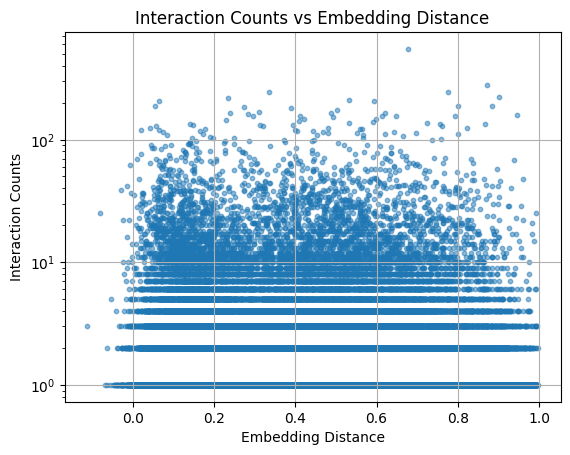

In [11]:
import matplotlib.pyplot as plt

plt.scatter(distances, interaction_strengths, alpha=0.5, s=10)
plt.title("Interaction Counts vs Embedding Distance")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/embedding_distrib_vs_interaction_count_skipgram.png')
plt.show()